## Notebook概要
- 目的は[Fairlean](https://fairlearn.org/main/quickstart.html#)で準備されている公平性指標や緩和アルゴリズムを使用を通じたAI公平性ツール理解の補助。
- 使用する[Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult)は性別、年齢などの個人情報と共に収入が50k以上かどうかのラベルを提供。
- 上記ラベルを予測する機械学習モデルと対象としてFairlearnを使用。

## 注意事項
- [MLSE夏合宿2022](https://sites.google.com/view/sig-mlse/%E6%B4%BB%E5%8B%95%E4%BA%88%E5%AE%9A/%E5%A4%8F%E5%90%88%E5%AE%BF2022)
AI公平性ツールミニチュートリアル向けに作成。
- Google Colabでの使用を想定。
- Fairlearnの[Quick Start](https://fairlearn.org/main/quickstart.html#)を参考に作成。

# ライブラリの準備

In [ ]:
!pip install fairlearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

import fairlearn
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 17.8 MB/s 


# データ準備
- 実験用に[Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult)をsklearnを用いてダウンロード。
- Fairlearnでは公平性の観点（sensitive feature）の指定が必要（今回は性別）。


In [80]:
data = fetch_openml(data_id=1590, as_frame=True)
X = pd.get_dummies(data.data)
y = (data.target == '>50K') * 1
sensitive = data.data['sex']
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Private,workclass_Self-emp-not-inc,workclass_Self-emp-inc,workclass_Federal-gov,...,native-country_Guatemala,native-country_Nicaragua,native-country_Scotland,native-country_Thailand,native-country_Yugoslavia,native-country_El-Salvador,native-country_Trinadad&Tobago,native-country_Peru,native-country_Hong,native-country_Holand-Netherlands
0,25.0,226802.0,7.0,0.0,0.0,40.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,89814.0,9.0,0.0,0.0,50.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 公平性評価
- 機械学習モデル（決定木）の公平性を２つの指標で評価。両指標ともに低いほどよく0が最小値。Fairlearnではこれら代表的な指標を計算する関数が準備されている。
  - Demographic Parity（DP）：結果の公平性指標
  - Equalized Odds（EO）：手続きの公平性指標

＊注意：
荒い説明なので、計算方法などの詳細は[公平性に配慮した機械学習](https://engineering.mercari.com/blog/entry/20211217-3286689d87/)をご参照ください。

- 基準となるモデルを決定木として学習し精度と2つの公平性指標を評価。

In [ ]:
base_classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)

In [81]:
classifier = base_classifier
classifier.fit(X, y)
pred = base_classifier.predict(X)
base_acc = accuracy_score(y_true=y, y_pred=pred)
base_dpd = fairlearn.metrics.demographic_parity_difference(y_true=y, y_pred=pred, sensitive_features=sensitive)
base_eod = fairlearn.metrics.equalized_odds_difference(y_true=y, y_pred=pred, sensitive_features=sensitive)
print(base_acc,base_dpd,base_eod)

0.8443552680070431 0.15004887369937472 0.0811655575720911


- 比較手法としてランダムな予測値で精度と2つの公平性指標を評価。

In [98]:
pred = np.random.randint(0,2,len(y))
random_acc = accuracy_score(y_true=y, y_pred=pred)
random_dpd = fairlearn.metrics.demographic_parity_difference(y_true=y, y_pred=pred, sensitive_features=sensitive)
random_eod = fairlearn.metrics.equalized_odds_difference(y_true=y, y_pred=pred, sensitive_features=sensitive)
print(random_acc,random_dpd,random_eod)

0.503071127308464 0.002828394639517229 0.004743817334933398


- 機械学習モデルを用いることでランダムな予測に比べて、精度は大幅に上回るものの２つの公平性指標が共に悪化。
- ランダムな予測では公平性指標はともに0（理想的な状態）に近い。

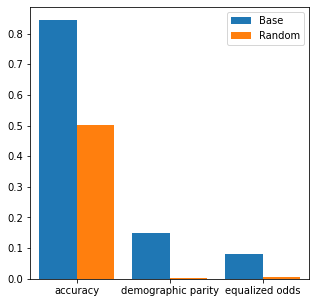

In [99]:
plt.figure(figsize=(5,5))
plt.bar([0.3,1.3,2.3],[base_acc,base_dpd,base_eod],width=0.4,label='Base')
plt.bar([0.7,1.7,2.7],[random_acc,random_dpd,random_eod],width=0.4,label='Random')
plt.xticks([0.5,1.5,2.5], labels=['accuracy','demographic parity','equalized odds'])
plt.xlim(0,3)
plt.legend()
plt.show()

## 緩和アルゴリズム
- Fairlearnでは指標を改善することを目的とした（不公平）緩和アルゴリズムが関数として用意されている。

- ExponentiatedGradientを用いた学習。
- ExponentiatedGradientではベースとなる学習アルゴリズムと低くしたい公平性指標の指定が必要。
- ベースを決定木、低くしたい指標をDemographic Parityとして実験。

In [100]:
classifier = base_classifier
constraint = DemographicParity()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y, sensitive_features=sensitive)
pred = mitigator.predict(X)
ex_dp_acc = accuracy_score(y_true=y, y_pred=pred)
ex_dp_dpd = fairlearn.metrics.demographic_parity_difference(y_true=y, y_pred=pred, sensitive_features=sensitive)
ex_dp_eod = fairlearn.metrics.equalized_odds_difference(y_true=y, y_pred=pred, sensitive_features=sensitive)
print(ex_dp_acc,ex_dp_dpd,ex_dp_eod)

0.8211989681012244 0.01539664152679332 0.2860753258688458


- 精度をあまり落とさずにDemographic Parityの緩和に成功。一方でEqulized Oddsは悪化。
- 直感的にはDemographic ParityとEqulized Oddsはトレードオフだから仕方ないと思える。

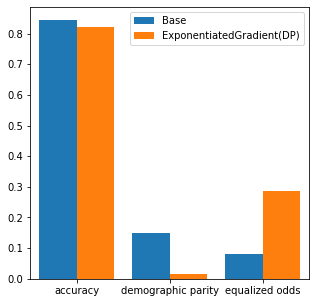

In [101]:
plt.figure(figsize=(5,5))
plt.bar([0.3,1.3,2.3],[base_acc,base_dpd,base_eod],width=0.4,label='Base')
plt.bar([0.7,1.7,2.7],[ex_dp_acc,ex_dp_dpd,ex_dp_eod],width=0.4,label='ExponentiatedGradient(DP)')
plt.xticks([0.5,1.5,2.5], labels=['accuracy','demographic parity','equalized odds'])
plt.xlim(0,3)
plt.legend()
plt.show()

- ベースを決定木、低くしたい指標をEqualized Oddsとして実験。

In [102]:
classifier = base_classifier
constraint = EqualizedOdds()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y, sensitive_features=sensitive)
pred = mitigator.predict(X)
ex_eo_acc = accuracy_score(y_true=y, y_pred=pred)
ex_eo_dpd = fairlearn.metrics.demographic_parity_difference(y_true=y, y_pred=pred, sensitive_features=sensitive)
ex_eo_eod = fairlearn.metrics.equalized_odds_difference(y_true=y, y_pred=pred, sensitive_features=sensitive)
print(ex_eo_acc,ex_eo_dpd,ex_eo_eod)

0.8389910323082593 0.10698914708036486 0.016596229049323424


- 精度をあまり落とさずにDemographic ParityとEqulized Oddsが共に改善。
- Demographic ParityとEqulized Oddsは完全にトレードオフな関係ではないことがわかる。

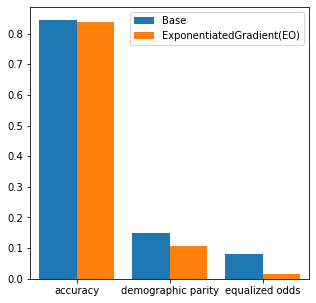

In [103]:
plt.figure(figsize=(5,5))
plt.bar([0.3,1.3,2.3],[base_acc,base_dpd,base_eod],width=0.4,label='Base')
plt.bar([0.7,1.7,2.7],[ex_eo_acc,ex_eo_dpd,ex_eo_eod],width=0.4,label='ExponentiatedGradient(EO)')
plt.xticks([0.5,1.5,2.5], labels=['accuracy','demographic parity','equalized odds'])
plt.xlim(0,3)
plt.legend()
plt.show()

- 結論：完全に公平なAIを開発するのは難しいが、精度をあまり落とさずに定められた複数の指標を改善する簡単な方法が存在する可能性がある。